In [1]:
!pip install keras_vggface
!pip install keras_applications

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 4.8 MB/s eta 0:00:00


In [8]:
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Flatten, Dense, Input, GlobalAveragePooling2D,Dropout, \
    GlobalMaxPooling2D, Activation, Conv2D, MaxPooling2D, BatchNormalization, \
    AveragePooling2D, Reshape, Permute, multiply
from keras.utils import layer_utils
from keras.utils.data_utils import get_file
from keras import backend as K
from keras.utils.layer_utils import get_source_inputs
import warnings
from keras.models import Model
from tensorflow.keras.optimizers import SGD,Adam
from keras import layers
import keras
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

In [3]:
%cd content

[Errno 2] No such file or directory: 'content'
/content


In [4]:
!gdown 1C92L4VqLNAxC1MhvlYkrC0wgXEsq2z51

Downloading...
From: https://drive.google.com/uc?id=1C92L4VqLNAxC1MhvlYkrC0wgXEsq2z51
To: /content/fer2013.zip
100% 63.3M/63.3M [00:02<00:00, 24.2MB/s]


In [5]:
!unzip fer2013.zip

Streaming output truncated to the last 5000 lines.
  inflating: train/sad/Training_65242339.jpg  
  inflating: train/sad/Training_65267116.jpg  
  inflating: train/sad/Training_65275626.jpg  
  inflating: train/sad/Training_6529266.jpg  
  inflating: train/sad/Training_65329617.jpg  
  inflating: train/sad/Training_65338712.jpg  
  inflating: train/sad/Training_65338797.jpg  
  inflating: train/sad/Training_65387162.jpg  
  inflating: train/sad/Training_65404494.jpg  
  inflating: train/sad/Training_65426218.jpg  
  inflating: train/sad/Training_65430136.jpg  
  inflating: train/sad/Training_65437377.jpg  
  inflating: train/sad/Training_6545735.jpg  
  inflating: train/sad/Training_65463385.jpg  
  inflating: train/sad/Training_65473985.jpg  
  inflating: train/sad/Training_65502829.jpg  
  inflating: train/sad/Training_65505359.jpg  
  inflating: train/sad/Training_65508578.jpg  
  inflating: train/sad/Training_65516023.jpg  
  inflating: train/sad/Training_65524027.jpg  
  inflating

In [4]:
train_dir = "./data/train/" # Directory containing the training data
test_dir = "./data/test/"  # Directory containing the validation data

In [9]:
#get train, val and test datasets
train_datagen = ImageDataGenerator(
        rescale = 1./255,
        # validation_split = 0.2,  
        width_shift_range=0.1,
        height_shift_range=0.1,
        zoom_range=0.1,
        horizontal_flip=True,
        rotation_range=10,
        # preprocessing_function= resize_for_transferLearning
        )

validation_datagen = ImageDataGenerator(rescale = 1./255,
                                  validation_split = 0.5
                                  )

In [10]:
BATCH_SIZE = 128
train_generator = train_datagen.flow_from_directory(
    directory = train_dir,           # Directory containing the training data
    target_size = (197, 197),          # Resizes all images to 48x48 pixels
    batch_size = BATCH_SIZE,                 # Number of images per batch
    color_mode = "rgb",        # Converts the images to grayscale
    class_mode = "categorical",      # Classifies the images into 7 categories
    # subset = "training"  ,            # Uses the training subset of the data
    shuffle=True
)

validation_generator = validation_datagen.flow_from_directory(
    directory = test_dir,            # Directory containing the validation data
    target_size = (197, 197),          # Resizes all images to 48x48 pixels
    batch_size = BATCH_SIZE,                 # Number of images per batch
    color_mode = "rgb",        # Converts the images to grayscale
    class_mode = "categorical",      # Classifies the images into 7 categories
    subset = "validation",           # Uses the training subset of the data
    shuffle=True
    )
test_generator = validation_datagen.flow_from_directory(
    directory = test_dir,            # Directory containing the validation data
    target_size = (197, 197),          # Resizes all images to 48x48 pixels
    batch_size = BATCH_SIZE,                 # Number of images per batch
    color_mode = "rgb",        # Converts the images to grayscale
    class_mode = "categorical",      # Classifies the images into 7 categories
    subset = "training",           # Uses the training subset of the data
    shuffle=True
    )

Found 28709 images belonging to 7 classes.
Found 3587 images belonging to 7 classes.
Found 3591 images belonging to 7 classes.


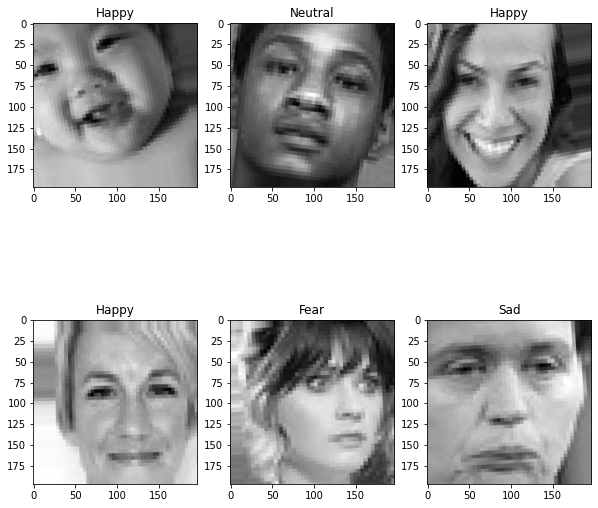

In [14]:
import random
import matplotlib.pyplot as plt
class_labels = ['Angry', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sad', 'Surprise']
img , label = train_generator.__next__()
subPlot =1
plt.figure(figsize=(10,10))
for j in range(1,7):
    i = random.randint(0,(img.shape[0]-1))
    image = img[i]
    labl = class_labels[label[i].argmax()]
    plt.subplot(2,3,subPlot)
    subPlot+=1
    plt.imshow(image[:,:,0], cmap="gray")
    plt.title(labl)
plt.show()

In [11]:
from keras import Model
from keras.layers import Flatten, Dense, Input
from keras_vggface.vggface import VGGFace

vgg_notop = VGGFace(model='resnet50', include_top=False, input_shape=(197, 197, 3), pooling='avg')
last_layer = vgg_notop.get_layer('avg_pool').output
x = Flatten(name='flatten')(last_layer)
x = Dropout(0.5)(x)
x = Dense(4096, activation='relu', name='fc6')(x)
x = Dropout(0.5)(x)
x = Dense(1024, activation='relu', name='fc7')(x)
x = Dropout(0.5)(x)
    
for i in range(170):
    vgg_notop.layers[i].trainable = False

out = Dense(7, activation='softmax', name='classifier')(x)

model = Model(vgg_notop.input, out)


optim = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
sgd = SGD(learning_rate=0.01, momentum=0.9, decay=0.0001, nesterov=True)

model.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['accuracy'])
# plot_model(model, to_file='model2.png', show_shapes=True)

94694792/94694792 [==============================] - 5s 0us/step


In [ ]:
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import shutil

# shutil.rmtree('./logs')
checkpoint_callback = ModelCheckpoint(
    filepath='model.h5',
    monitor='val_accuracy',
    save_best_only=True,
    save_weights_only=False,
    mode='max',
    verbose=1,
)
lrd = ReduceLROnPlateau(
    monitor = 'val_accuracy',
    patience = 10,
    verbose = 1,
    factor = 0.5,
    min_lr = 1e-10)

es = EarlyStopping(
    monitor='val_accuracy',
    mode='max',
    verbose=1,
    patience=20)

tb_callback = keras.callbacks.TensorBoard(log_dir='./logs', histogram_freq=1)

history = model.fit(
    train_generator,
    steps_per_epoch=28709 // BATCH_SIZE,
    epochs=100,
    validation_data=validation_generator,
    validation_steps=3509 // BATCH_SIZE,
    callbacks=[checkpoint_callback,lrd,tb_callback]
)

Epoch 1/100
224/224 [==============================] - ETA: 0s - loss: 1.8780 - accuracy: 0.3347
Epoch 1: val_accuracy improved from -inf to 0.16956, saving model to model.h5
224/224 [==============================] - 353s 1s/step - loss: 1.8780 - accuracy: 0.3347 - val_loss: 1.8779 - val_accuracy: 0.1696 - lr: 0.0100
Epoch 2/100
224/224 [==============================] - ETA: 0s - loss: 1.3799 - accuracy: 0.4756
Epoch 2: val_accuracy improved from 0.16956 to 0.18027, saving model to model.h5
224/224 [==============================] - 329s 1s/step - loss: 1.3799 - accuracy: 0.4756 - val_loss: 1.9599 - val_accuracy: 0.1803 - lr: 0.0100
Epoch 3/100
224/224 [==============================] - ETA: 0s - loss: 1.2749 - accuracy: 0.5213
Epoch 3: val_accuracy improved from 0.18027 to 0.41956, saving model to model.h5
224/224 [==============================] - 329s 1s/step - loss: 1.2749 - accuracy: 0.5213 - val_loss: 1.4853 - val_accuracy: 0.4196 - lr: 0.0100
Epoch 4/100
224/224 [=============

In [2]:
from keras.models import load_model
model = load_model('Resnet_model.h5')
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 197, 197, 3) 0                                            
__________________________________________________________________________________________________
conv1/7x7_s2 (Conv2D)           (None, 99, 99, 64)   9408        input_1[0][0]                    
__________________________________________________________________________________________________
conv1/7x7_s2/bn (BatchNormaliza (None, 99, 99, 64)   256         conv1/7x7_s2[0][0]               
__________________________________________________________________________________________________
activation (Activation)         (None, 99, 99, 64)   0           conv1/7x7_s2/bn[0][0]            
______________________________________________________________________________________________

In [13]:
import numpy as np
def getValues(filename, lossType):
    
    with open(filename, 'r',encoding="utf8") as file:
        content = file.read()
        words = content.split()
        l = []
        for i in range(len(words)):
            if words[i] == lossType:
                try:
                    loss_number = float(words[i+1])
                    l.append(loss_number)
                except ValueError:
                    print(f"Invalid number format after 'loss:' at position {i+1}.")
                    return None
        return l
    

train_acc = np.array(getValues('acc.txt','accuracy:'))
train_acc = np.unique(train_acc)
val_acc = np.array(getValues('acc.txt','val_accuracy:'))
train_loss = np.array(getValues('acc.txt','loss:'))
train_loss = np.unique(train_loss)
val_loss = np.array(getValues('acc.txt','val_loss:'))

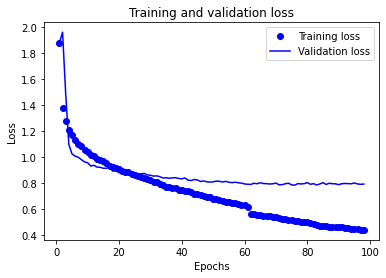

In [14]:
import matplotlib.pyplot as plt

# Plot the train and validation loss
train_loss = np.flip(train_loss)
val_loss = val_loss
epochs = range(1, len(train_loss) + 1)
plt.plot(epochs, train_loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

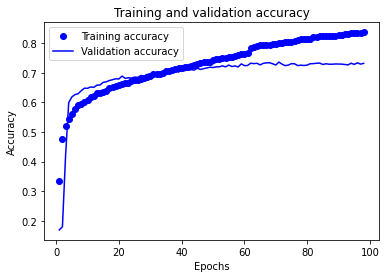

In [18]:
# Plot the train and validation accuracy
# train_acc = history.history['accuracy']
# val_acc = history.history['val_accuracy']
plt.plot(epochs, train_acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [21]:
val_loss, val_acc   = model.evaluate(validation_generator)
test_loss, test_acc   = model.evaluate(test_generator)
print("test accuracy = {:.2f}".format(test_acc*100))
print("validation accuracy = {:.2f}".format(val_acc*100))

29/29 [==============================] - 10s 328ms/step - loss: 0.8504 - accuracy: 0.7065
test accuracy = 70.65
validation accuracy = 73.43


In [17]:
validation_generator.class_indices

{'angry': 0,
 'disgust': 1,
 'fear': 2,
 'happy': 3,
 'neutral': 4,
 'sad': 5,
 'surprise': 6}

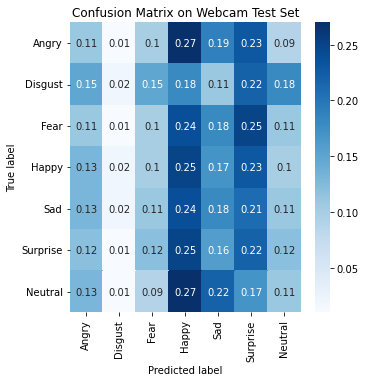

In [18]:
from sklearn.metrics import confusion_matrix
from seaborn import heatmap
import pandas as pd

y_pred_probs = model.predict(validation_generator)
y_pred = y_pred_probs.argmax(axis=1)
y_true = validation_generator.classes

emotions = {0:'Angry', 1:'Disgust', 2:'Fear', 3:'Happy', 4:'Sad', 5:'Surprise', 6:'Neutral'}

cmat_df_test=pd.DataFrame(
  confusion_matrix(y_true, y_pred, normalize='true').round(2),
  index=emotions.values(), 
  columns=emotions.values()
  )

plt.figure(figsize=(5,5))
heatmap(cmat_df_test,annot=True,cmap=plt.cm.Blues)
plt.tight_layout()
plt.title('Confusion Matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

[0 3 4 ... 4 3 4]
Confusion Matrix
[[ 65   5  49 121  86  94  59]
 [ 11   1   6  15   9  10   3]
 [ 58   7  55 137  95 108  52]
 [113  11  94 207 166 205  91]
 [ 68   7  59 152 112 150  68]
 [ 79   7  73 159 100 123  82]
 [ 44   9  38 109  78 100  37]]
Classification Report
              precision    recall  f1-score   support

       angry       0.15      0.14      0.14       479
     disgust       0.02      0.02      0.02        55
        fear       0.15      0.11      0.12       512
       happy       0.23      0.23      0.23       887
     neutral       0.17      0.18      0.18       616
         sad       0.16      0.20      0.17       623
    surprise       0.09      0.09      0.09       415

    accuracy                           0.17      3587
   macro avg       0.14      0.14      0.14      3587
weighted avg       0.17      0.17      0.17      3587



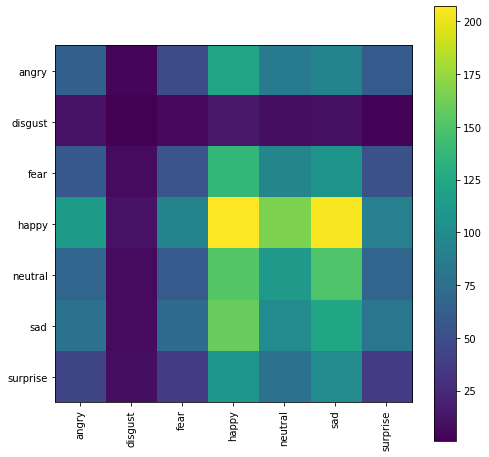

In [15]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix

y_pred = model.predict(validation_generator)
y_pred = np.argmax(y_pred, axis=1)
class_labels = validation_generator.class_indices
class_labels = {v:k for k,v in class_labels.items()}


cm_test = confusion_matrix(validation_generator.classes, y_pred)
print('Confusion Matrix')
print(cm_test)
print('Classification Report')
target_names = list(class_labels.values())
print(classification_report(validation_generator.classes, y_pred, target_names=target_names))

plt.figure(figsize=(8,8))
plt.imshow(cm_test, interpolation='nearest')
plt.colorbar()
tick_mark = np.arange(len(target_names))
_ = plt.xticks(tick_mark, target_names, rotation=90)
_ = plt.yticks(tick_mark, target_names)